El objetivo de la siguiente prediccion es determinar la evolución de los precios.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import statsmodels as sm
from statsmodels.graphics import tsaplots

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error

import warnings
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('State_time_series_Final.csv')

In [3]:
data['Date'] = pd.to_datetime(data.Date)

In [4]:
df_ts = pd.DataFrame(zip(data['Date'], data['MedianListingPrice_AllHomes'],data['Sale_Prices'], data['Sale_Counts']),
        columns=['Date', 'MedianListingPrice_AllHomes','Sale_Prices', 'Sale_Counts'])

data_drop = df_ts.dropna(thresh=3)
data_drop.reset_index(drop = True)

,Date,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts
0,2012-01-31,149900.0,181050.0,2603.0
1,2012-01-31,229000.0,181050.0,5173.0
2,2012-01-31,207500.0,127100.0,9164.0
3,2012-01-31,139900.0,181050.0,1514.0
4,2012-01-31,207500.0,245000.0,27029.0
...,...,...,...,...
3667,2017-12-31,289000.0,181050.0,5173.0
3668,2017-12-31,349950.0,181050.0,5173.0
3669,2017-12-31,149900.0,181050.0,5173.0
3670,2017-12-31,189900.0,181050.0,5173.0


In [5]:
data_drop['Sales'] = df_ts['Sale_Prices']*df_ts['Sale_Counts']

In [6]:
data_drop.head(3)

,Date,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts,Sales
0,2012-01-31,149900.0,181050.0,2603.0,4.712732e+08
1,2012-01-31,229000.0,181050.0,5173.0,9.365716e+08
2,2012-01-31,207500.0,127100.0,9164.0,1.164744e+09


In [7]:
for col in df_ts.columns:
    # Determina si hay outliers para separarlos y poder imputar los valores faltantes de manera que no se vean afectados
    # por los valores atípicos
    if df_ts.loc[:,col].dtype!=object:

        Q1 = df_ts[col].quantile(0.25)
        Q3 = df_ts[col].quantile(0.75)
        IQR = Q3 - Q1
        BI = Q1 - 1.5*IQR
        BS = Q3 + 1.5*IQR

        out = (df_ts[col] < BI) | (df_ts[col] > BS)
    
    data_drop[col] = df_ts[col][~out]

In [8]:
len(df_ts.Date.unique())

72

In [9]:
data_month = data_drop.resample('M',on='Date').mean()
df_aux = data_month.reset_index()

df_ts = df_aux
df_ts['Date'] = df_aux['Date'].dt.to_period('M')
df_ts.set_index(['Date'],inplace = True)
df_ts.head()

,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts,Sales
Date,,,,
2012-01,186217.29,170674.0,4143.204082,8.290139e+08
2012-02,186866.94,169831.0,4202.816327,8.456398e+08
2012-03,189243.83,170393.0,4706.687500,1.039651e+09
2012-04,190602.20,171191.0,4788.916667,1.056214e+09
2012-05,190900.50,171174.0,5135.531915,1.216632e+09


In [10]:
diff_1 = df_aux['MedianListingPrice_AllHomes'].diff()
fo=list(diff_1)
df_aux['Diff_1_AllHomes_Price']=fo
df_aux

,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts,Sales,Diff_1_AllHomes_Price
Date,,,,,
2012-01,186217.290000,170674.000000,4143.204082,8.290139e+08,NaN
2012-02,186866.940000,169831.000000,4202.816327,8.456398e+08,649.650000
2012-03,189243.830000,170393.000000,4706.687500,1.039651e+09,2376.890000
2012-04,190602.200000,171191.000000,4788.916667,1.056214e+09,1358.370000
2012-05,190900.500000,171174.000000,5135.531915,1.216632e+09,298.300000
...,...,...,...,...,...
2017-08,241460.319149,198148.913043,7070.227273,2.392792e+09,-2041.446809
2017-09,239093.097826,199333.695652,7176.604167,2.035790e+09,-2367.221323
2017-10,238629.880435,200748.913043,7127.458333,2.068920e+09,-463.217391


<function matplotlib.pyplot.show(close=None, block=None)>

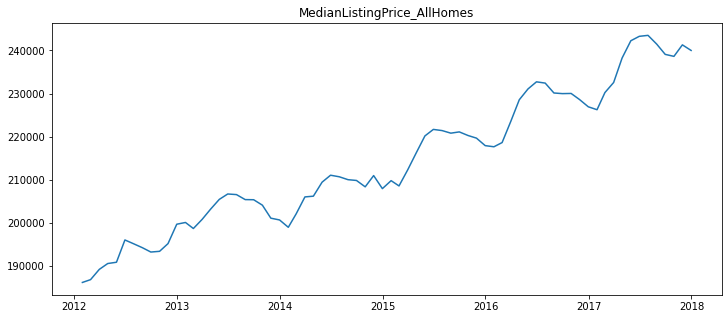

In [11]:
plt.figure(figsize=(12,5))
df_aux = data_month.reset_index()

plt.plot(df_aux.Date, df_aux.MedianListingPrice_AllHomes)
plt.title('MedianListingPrice_AllHomes')
plt.show

# - Test Dickey-fuller

In [12]:
from statsmodels.tsa.stattools import adfuller

print("Observations of Dickey-fuller test")
dftest = adfuller(df_aux.MedianListingPrice_AllHomes,autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  0.442940
p-value                         0.983032
#lags used                      8.000000
number of observations used    63.000000
critical value (1%)            -3.538695
critical value (5%)            -2.908645
critical value (10%)           -2.591897
dtype: float64


Evidencia débil contra la hipótesis nula, lo cual significa que la serie de tiempo tiene una raíz unitaria que indica que no es estacionaria.

#### - Estacional de primer orden

In [13]:
from statsmodels.tsa.stattools import adfuller

print("Observations of Dickey-fuller test")
dftest = adfuller(diff_1.dropna(),autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                -6.680889e+00
p-value                        4.345243e-09
#lags used                     7.000000e+00
number of observations used    6.300000e+01
critical value (1%)           -3.538695e+00
critical value (5%)           -2.908645e+00
critical value (10%)          -2.591897e+00
dtype: float64


El valor de p es menor a 0.05, lo que significa que podemos recharzar la hipótesis nula H0. Podemos concluir que los datos no tienen raíz unitaria y son estacionarios.

### - Tendencia, Estacionalidad, Residuos

In [14]:
df_ts.index=df_ts.index.to_timestamp()
aux = seasonal_decompose(df_ts['MedianListingPrice_AllHomes'], model = "add")

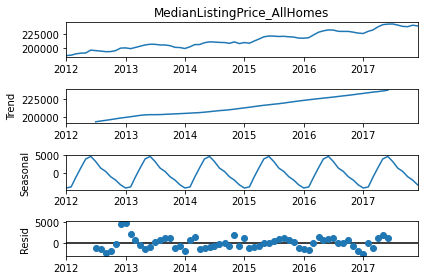

In [15]:
aux.plot();

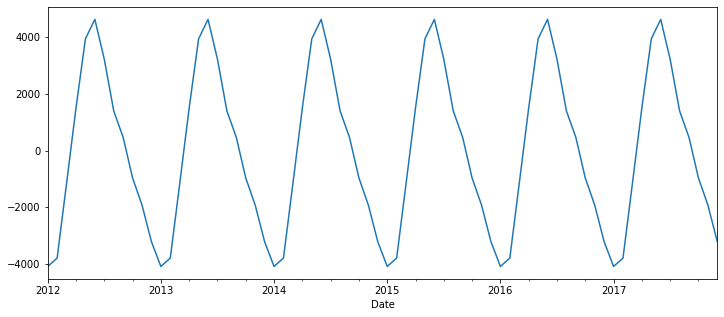

In [16]:
plt.figure(figsize = (12,5))
aux.seasonal.plot();

---

# - ARIMA

In [17]:
x = df_ts['MedianListingPrice_AllHomes'].diff().dropna()

### Correlogramas

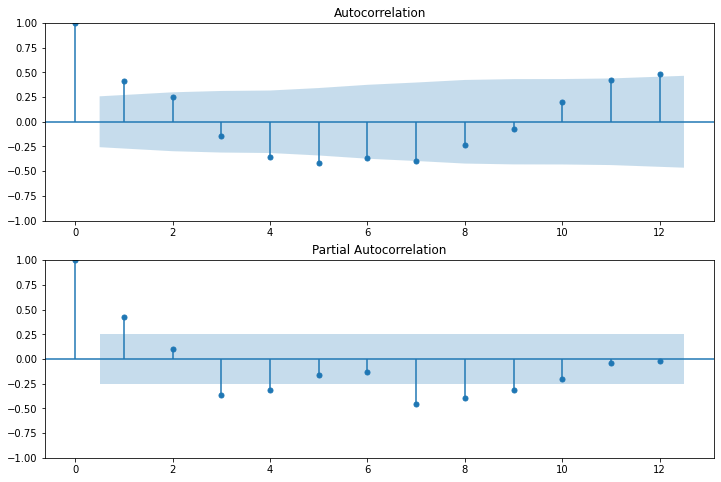

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(x.iloc[13:],lags=12,ax=ax1)
ax2 = fig.add_subplot(212)
fig = tsaplots.plot_pacf(x.iloc[13:],lags=12,ax=ax2)

### Datos: Train y Test

In [19]:
train = df_aux[0:int(len(df_aux)*.80)]
test = df_aux[int(len(df_aux)*.80):len(df_aux)]

size = len(df_aux) - 12
train, test = df_aux[0:size], df_aux[size:]

### Determinación de mejores parámetros 

In [20]:
arima_model =  auto_arima(train['MedianListingPrice_AllHomes'],start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 20 )
print(arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1017.808, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1020.555, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1020.059, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1023.316, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1021.658, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.077 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   57
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -506.904
Date:                Tue, 06 Dec 2022   AIC                           1017.808
Time:                        15:57:15   BIC                           1021.858
Sample:                             0   HQIC                          1019.378
                                 - 57                                       

### Entrenamiento del modelo

In [21]:
from statsmodels.tsa.arima.model import ARIMA

In [22]:
model = ARIMA(train['MedianListingPrice_AllHomes'], order=(0,1,0))
arima_fit = model.fit()

In [23]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:     MedianListingPrice_AllHomes   No. Observations:                   57
Model:                          ARIMA(0, 1, 0)   Log Likelihood                -510.658
Date:                         Tue, 06 Dec 2022   AIC                           1023.316
Time:                                 15:57:15   BIC                           1025.341
Sample:                                      0   HQIC                          1024.101
                                          - 57                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       4.79e+06   9.02e+05      5.311      0.000    3.02e+06    6.56e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.78   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.03   Prob(JB):                         0.27
Heteroskedasticity (H):               1.44   Skew:                             0.41
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
fc = arima_fit.forecast(len(test), alpha=0.05) 
fc_arima = pd.Series(fc, index=test.index)

In [25]:
fc_arima

57    229994.28125
58    229994.28125
59    229994.28125
60    229994.28125
61    229994.28125
62    229994.28125
63    229994.28125
64    229994.28125
65    229994.28125
66    229994.28125
67    229994.28125
68    229994.28125
69    229994.28125
70    229994.28125
71    229994.28125
Name: predicted_mean, dtype: float64

In [26]:
comp_pred = pd.DataFrame()
comp_pred['ARIMA'] = fc_arima
comp_pred.head()

,ARIMA
57,229994.28125
58,229994.28125
59,229994.28125
60,229994.28125
61,229994.28125


### Evaluación del modelo

In [27]:
MSE_arima = mean_squared_error(test['MedianListingPrice_AllHomes'], fc_arima)
RMSE_arima = np.sqrt(MSE_arima)
print('MSE: ',MSE_arima)
print('RMSE: ',RMSE_arima)

MSE:  75053293.03754775
RMSE:  8663.3303664092


In [28]:
# MAPE: Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true)*100)

In [29]:
MAPE_arima = mape(test['MedianListingPrice_AllHomes'], fc_arima) 
print('MAPE: ',round(MAPE_arima,2),'%')

MAPE:  3.03 %


In [30]:
comp_error = pd.DataFrame([MSE_arima, RMSE_arima, MAPE_arima], columns = ['ARIMA'], index= ['MSE', 'RMSE', 'MAPE']) 

In [31]:
comp_error

,ARIMA
MSE,7.505329e+07
RMSE,8.663330e+03
MAPE,3.025849e+00


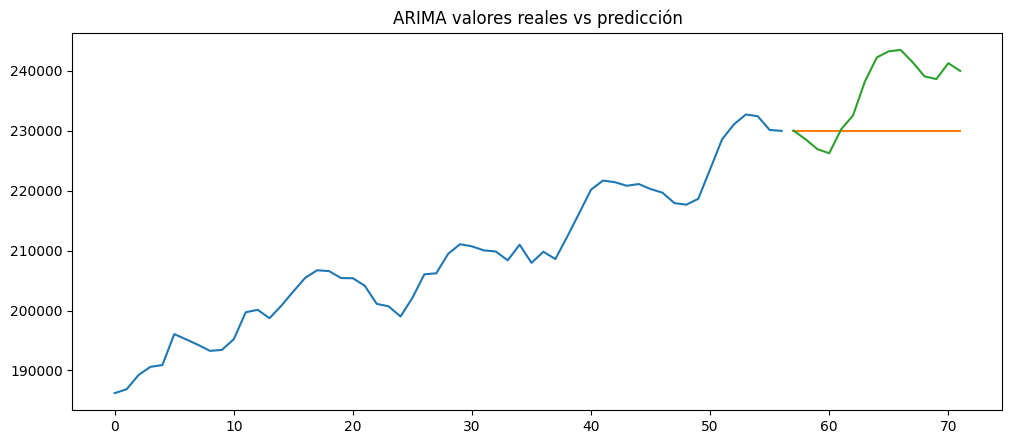

In [32]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['MedianListingPrice_AllHomes'], label='training')
plt.plot(fc_arima, label='forecast')
plt.plot(test['MedianListingPrice_AllHomes'], label='actual')


plt.title('ARIMA valores reales vs predicción')
plt.show();

### Predicción

In [33]:
# Entreno el modelo con todos los datos
model = ARIMA(df_ts['MedianListingPrice_AllHomes'], order=(0,1,0))
arima_fit = model.fit()

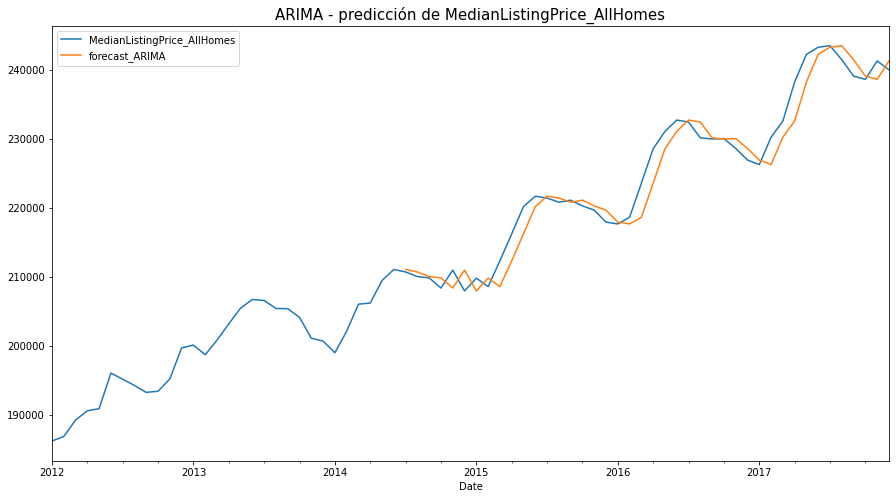

In [34]:
df_ts['forecast_ARIMA']=arima_fit.predict(start = 30, end = 156)
df_ts[['MedianListingPrice_AllHomes','forecast_ARIMA']].plot(figsize=(15,8))
plt.title('ARIMA - predicción de MedianListingPrice_AllHomes', fontsize = 15)
plt.show()

In [35]:
from pandas.tseries.offsets import DateOffset

future_arima = [df_ts.index[-1]+ DateOffset(months=x)for x in range(0,24)] # 2 años = 24 meses

In [36]:
future_df_ARIMA = pd.DataFrame(index=future_arima[1:],columns=df_ts.columns)

In [37]:
future_df = pd.concat([df_ts,future_df_ARIMA ]) # Concatenamos los dos dataframes

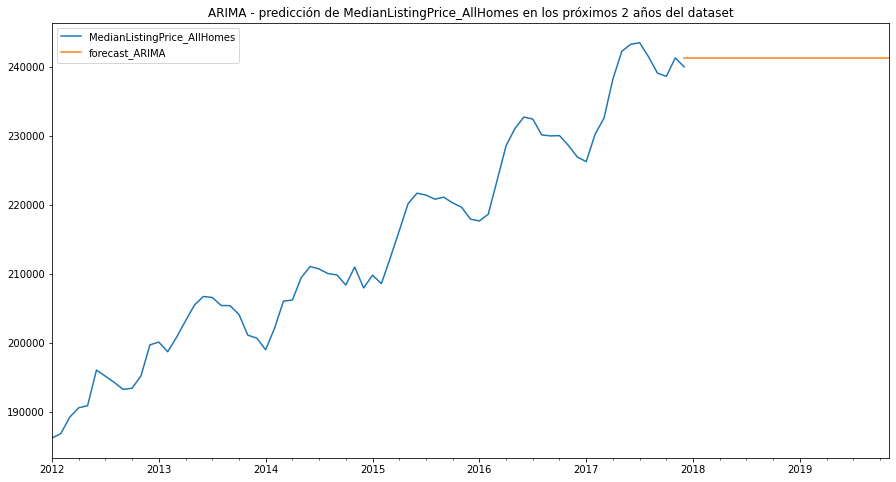

In [38]:
future_df['forecast_ARIMA'] = arima_fit.predict(start = 71, end = 156, dynamic= True)  
future_df[['MedianListingPrice_AllHomes', 'forecast_ARIMA']].plot(figsize=(15, 8)) 
plt.title('ARIMA - predicción de MedianListingPrice_AllHomes en los próximos 2 años del dataset')
plt.show()

---

## - SARIMA

### Datos: Train y Test

In [39]:
train = df_aux[0:int(len(df_aux)*.80)]
test = df_aux[int(len(df_aux)*.80):len(df_aux)]

### Determinación de mejores parámetros 

In [40]:
sarima_model =  auto_arima(train['MedianListingPrice_AllHomes'],start_p=0, d=1, start_q=0, 
                          max_p=6, max_d=6, max_q=6, start_P=0, 
                          D=1, start_Q=0, max_P=6, max_D=6,
                          max_Q=6, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 20 )
print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=806.315, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=809.402, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=809.448, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=815.489, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=808.073, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=807.630, Time=0.01 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=807.685, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=809.780, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=808.197, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.461 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(0, 1

### Entrenamiento del modelo

In [41]:
sarima_model = SARIMAX(train['MedianListingPrice_AllHomes'], order=(0,1,0),seasonal_order=(0,1,0,12))
sarima_fit = sarima_model.fit(disp=1)

In [42]:
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:        MedianListingPrice_AllHomes   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -402.157
Date:                            Tue, 06 Dec 2022   AIC                            806.315
Time:                                    15:57:16   BIC                            808.099
Sample:                                         0   HQIC                           806.976
                                             - 57                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       5.01e+06   9.76e+05      5.134      0.000     3.1e+06    6.92e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.44   Prob(JB):                         0.90
Heteroskedasticity (H):               0.27   Skew:                             0.01
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Evaluación del modelo

In [43]:
sarima_fc_series = sarima_fit.forecast(len(test), alpha=0.05) 
MSE_sarima = mean_squared_error(test['MedianListingPrice_AllHomes'], sarima_fc_series)
RMSE_sarima = np.sqrt(MSE_sarima)

print('MSE:', MSE_sarima)
print('RMSE:', RMSE_sarima)

MSE: 4118626.9962368975
RMSE: 2029.4400696342077


In [44]:
MAPE_sarima = mape(test['MedianListingPrice_AllHomes'], sarima_fc_series) 
print('MAPE: ',round(MAPE_sarima,2),'%')

MAPE:  0.63 %


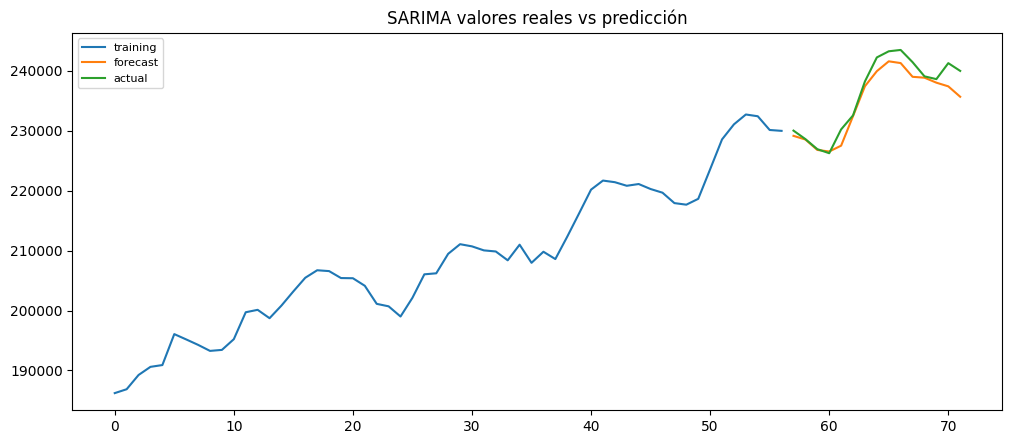

In [45]:
sarima_fc_series = pd.Series(sarima_fc_series, index=test.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train['MedianListingPrice_AllHomes'], label='training')
plt.plot(sarima_fc_series, label='forecast')
plt.plot(test['MedianListingPrice_AllHomes'], label='actual')


plt.title('SARIMA valores reales vs predicción')
plt.legend(loc='upper left', fontsize=8);

In [46]:
comp_pred['SARIMA'] = sarima_fc_series
comp_pred.head()

,ARIMA,SARIMA
57,229994.28125,229160.760417
58,229994.28125,228547.875000
59,229994.28125,226810.406250
60,229994.28125,226547.197917
61,229994.28125,227522.197917


In [47]:
comp_error['SAMRIMA'] = [MSE_sarima, RMSE_sarima, MAPE_sarima]
comp_error

,ARIMA,SAMRIMA
MSE,7.505329e+07,4.118627e+06
RMSE,8.663330e+03,2.029440e+03
MAPE,3.025849e+00,6.301242e-01


### Predicción

In [48]:
sarima_model = sm.tsa.statespace.sarimax.SARIMAX(df_ts['MedianListingPrice_AllHomes'], order=(0,1,0),seasonal_order=(0,1,0,12))
sarima_fit = sarima_model.fit(disp=0)

In [49]:
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:        MedianListingPrice_AllHomes   No. Observations:                   72
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -535.759
Date:                            Tue, 06 Dec 2022   AIC                           1073.518
Time:                                    15:57:17   BIC                           1075.596
Sample:                                01-01-2012   HQIC                          1074.329
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.485e+06   7.33e+05      6.121      0.000    3.05e+06    5.92e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.19   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.27   Prob(JB):                         0.73
Heteroskedasticity (H):               0.44   Skew:                             0.02
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

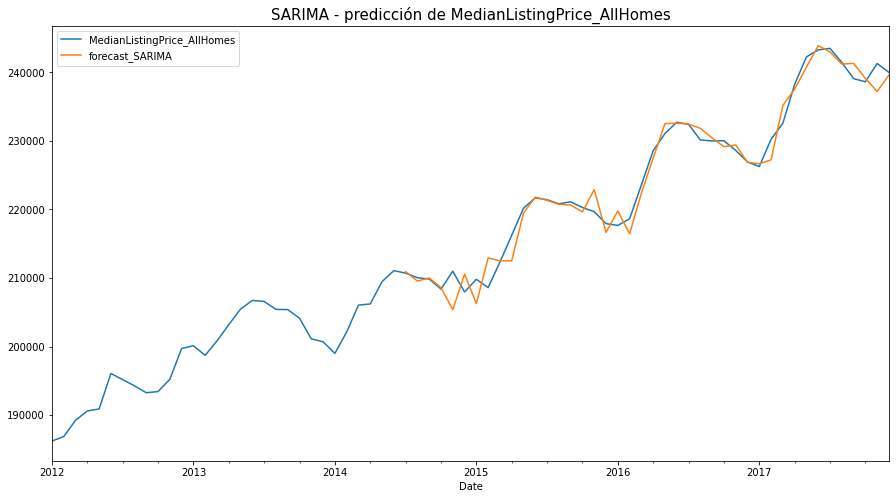

In [50]:
df_ts['forecast_SARIMA']=sarima_fit.predict(start = 30, end = 156)
df_ts[['MedianListingPrice_AllHomes','forecast_SARIMA']].plot(figsize=(15,8))
plt.title('SARIMA - predicción de MedianListingPrice_AllHomes', fontsize = 15)
plt.show()

In [51]:
from pandas.tseries.offsets import DateOffset

future_sarima = [df_ts.index[-1]+ DateOffset(months=x)for x in range(0,24)] # 2 años = 24 meses

In [52]:
future_df_SARIMA = pd.DataFrame(index=future_sarima[1:],columns=df_ts.columns)

In [53]:
future_df_SARIMA  = pd.concat([df_ts,future_df_SARIMA]) # Concatenamos los dos dataframes

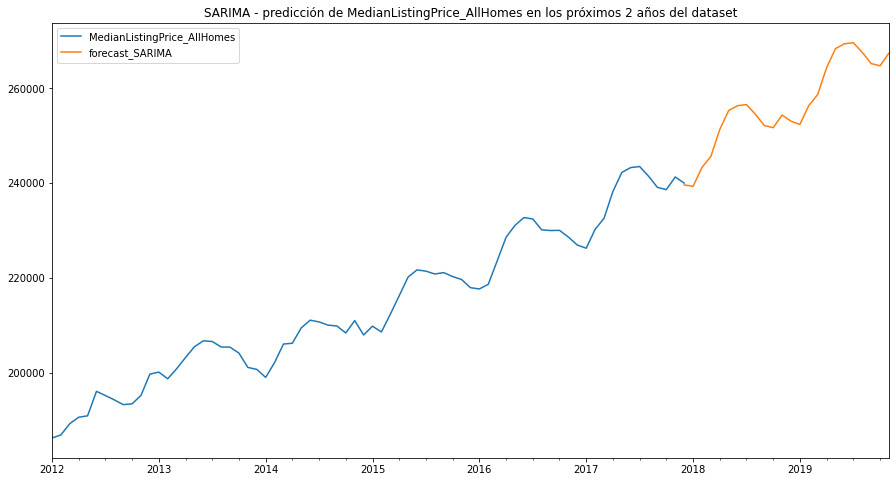

In [54]:
future_df_SARIMA ['forecast_SARIMA'] = sarima_fit.predict(start = 71, end = 156)  
future_df_SARIMA [['MedianListingPrice_AllHomes', 'forecast_SARIMA']].plot(figsize=(15, 8)) 
plt.title('SARIMA - predicción de MedianListingPrice_AllHomes en los próximos 2 años del dataset')
plt.show()

---

# PROPHET

In [55]:
data_month = data_drop.resample('M',on='Date').mean()
df_aux_prophet = data_month.reset_index()

df_ts_prophet = df_aux_prophet
df_ts_prophet['Date'] = df_aux['Date'].dt.to_period('W')
df_ts_prophet.set_index(['Date'],inplace = True)
df_ts_prophet.head()

,MedianListingPrice_AllHomes,Sale_Prices,Sale_Counts,Sales
Date,,,,
2012-01-30/2012-02-05,186217.29,170674.0,4143.204082,8.290139e+08
2012-02-27/2012-03-04,186866.94,169831.0,4202.816327,8.456398e+08
2012-03-26/2012-04-01,189243.83,170393.0,4706.687500,1.039651e+09
2012-04-30/2012-05-06,190602.20,171191.0,4788.916667,1.056214e+09
2012-05-28/2012-06-03,190900.50,171174.0,5135.531915,1.216632e+09


In [56]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [57]:
# Prophet trabaja la columna Date con el nombre 'ds' y la columna con las etiquetas con el nombre 'y'
df_ts_prophet = df_ts.drop(columns= ['Sale_Prices', 'Sale_Counts', 'Sales', 'Diff_1_AllHomes_Price', 'forecast_ARIMA', 'forecast_SARIMA'])
df_ts_prophet.reset_index(level= 0, inplace= True)
df_ts_prophet.rename(columns= {'Date': 'ds', 'MedianListingPrice_AllHomes' : 'y'}, inplace = True)

### Entrenamiento del modelo

In [58]:
# Instanciamos un modelo de Prophet

prophet = Prophet(yearly_seasonality= True, uncertainty_samples = 50, mcmc_samples=50, interval_width= 0.6)

# Entrenamos el modelo
prophet.fit(df_ts_prophet)

# Construimos un dataframe con los x valores futuros que querámos predecir. En este caso, 2 años.
future = prophet.make_future_dataframe(periods=(2*12), freq='M')

# Predecimos
forecast_prophet = prophet.predict(future)

15:57:18 - cmdstanpy - INFO - CmdStan installation c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
15:57:18 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:57:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                 
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                 
chain 4 |██████████| 00:00 Sampling completed                   


15:57:18 - cmdstanpy - INFO - CmdStan done processing.
15:57:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
15:57:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 iterations at ma

### - PREDICCIÓN

In [59]:
# yhat: valor pronosticado , (yhat_lower, yhat_upper): valores entre los que varia la prediccion, 
prophet_pred = prophet.predict(future)
prophet_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,187654.402173,180460.450775,185783.850566,186303.688138,189243.582359,-4438.627563,-5745.924718,-3129.028241,-4438.627563,-5745.924718,-3129.028241,0.0,0.0,0.0,183215.774611
1,2012-02-01,188477.196961,183318.385421,186982.630415,187511.432445,189509.252420,-3330.534842,-3938.344619,-2659.040088,-3330.534842,-3938.344619,-2659.040088,0.0,0.0,0.0,185146.662120
2,2012-03-01,189246.908215,186863.938005,190358.806817,188566.432550,189904.225546,-950.400845,-1610.410211,-95.595389,-950.400845,-1610.410211,-95.595389,0.0,0.0,0.0,188296.507370
3,2012-04-01,190095.129383,189687.206981,192933.358549,189391.479533,190819.797518,1347.676159,456.375632,2257.229996,1347.676159,456.375632,2257.229996,0.0,0.0,0.0,191442.805542
4,2012-05-01,190915.988578,191763.610271,195316.548259,190406.452040,191640.997072,2210.347521,1140.905785,3380.628515,2210.347521,1140.905785,3380.628515,0.0,0.0,0.0,193126.336099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2019-07-31,261123.762039,254739.288051,268897.587338,256130.523901,269119.350427,-315.241071,-4025.855437,1811.193206,-315.241071,-4025.855437,1811.193206,0.0,0.0,0.0,260808.520968
92,2019-08-31,262033.614602,260957.981460,275998.132563,256582.362458,270548.611737,5347.046167,1697.593472,8843.588946,5347.046167,1697.593472,8843.588946,0.0,0.0,0.0,267380.660769
93,2019-09-30,262914.117082,254132.400454,270265.246541,257051.515409,271692.668083,-2178.316361,-5079.478526,-129.629089,-2178.316361,-5079.478526,-129.629089,0.0,0.0,0.0,260735.800721
94,2019-10-31,263823.969644,254873.140113,272986.528466,257502.315070,272701.967132,-980.314679,-2691.147890,475.287120,-980.314679,-2691.147890,475.287120,0.0,0.0,0.0,262843.654965


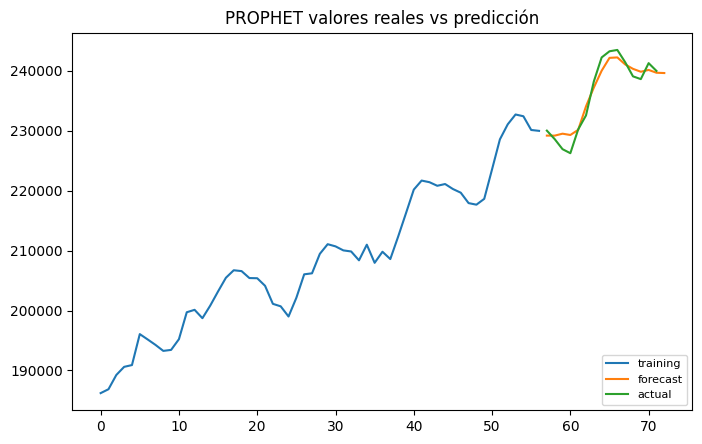

In [60]:
# Plot
plt.figure(figsize=(8,5), dpi=100)
plt.plot(train['MedianListingPrice_AllHomes'], label='training')
plt.plot(prophet_pred.yhat[57:73], label='forecast')
plt.plot(test['MedianListingPrice_AllHomes'], label='actual')


plt.title('PROPHET valores reales vs predicción')
plt.legend(loc='lower right', fontsize=8)
plt.show();

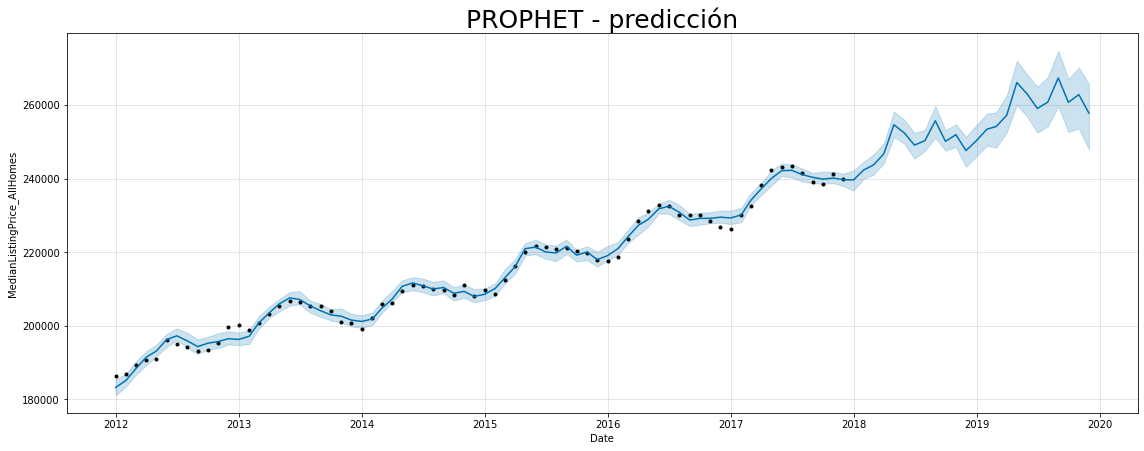

In [61]:
# plot forecasts

prophet.plot(forecast_prophet, xlabel='Date', ylabel='MedianListingPrice_AllHomes', figsize = (16,6))
plt.title('PROPHET - predicción', fontsize = 25)
plt.show()

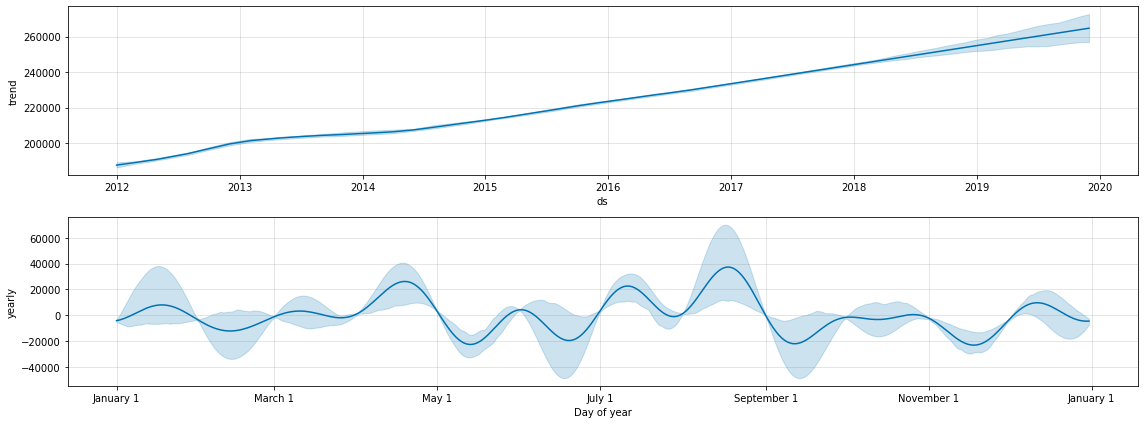

In [62]:
# Ploteamos los componentes de nuestra serie de tiempo

components = prophet.plot_components(forecast_prophet, figsize=(16,6))

### - Evaluación del modelo

In [63]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [64]:
df_cv = cross_validation(model=prophet, horizon= '365 days')

  0%|          | 0/4 [00:00<?, ?it/s]15:57:19 - cmdstanpy - INFO - CmdStan installation c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
15:57:19 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:57:19 - cmdstanpy - INFO - CmdStan start processing








chain 1 |██████████| 00:00 Sampling completed                   

chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                   



chain 4 |██████████| 00:00 Sampling completed


15:57:19 - cmdstanpy - INFO - CmdStan done processing.
15:57:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
15:57:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 11 divergent transit

15:57:19 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:57:19 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed                   
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                 
chain 4 |██████████| 00:00 Sampling completed                 


15:57:19 - cmdstanpy - INFO - CmdStan done processing.
15:57:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
15:57:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 21 div

15:57:20 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:57:20 - cmdstanpy - INFO - CmdStan start processing












chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                   
chain 3 |██████████| 00:00 Sampling completed                 
chain 4 |██████████| 00:00 Sampling completed                   


15:57:20 - cmdstanpy - INFO - CmdStan done processing.
15:57:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
15:57:20 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 25 divergent trans

15:57:20 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:57:20 - cmdstanpy - INFO - CmdStan start processing










chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                   


chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                   


15:57:20 - cmdstanpy - INFO - CmdStan done processing.
15:57:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
15:57:20 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 16 divergent trans

In [65]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-07-01,219888.649126,216419.771824,222791.674396,221424.854167,2015-06-02 12:00:00
1,2015-08-01,220878.398479,217548.237416,225748.866821,220826.250000,2015-06-02 12:00:00
2,2015-09-01,218278.737071,214822.652862,221457.261373,221118.937500,2015-06-02 12:00:00
3,2015-10-01,221504.270041,218616.055937,224597.099386,220285.416667,2015-06-02 12:00:00
4,2015-11-01,222330.584332,217143.164062,227441.354329,219672.531250,2015-06-02 12:00:00
5,2015-12-01,219447.743787,216823.691346,223616.105389,217935.062500,2015-06-02 12:00:00
6,2016-01-01,221205.178122,217902.585610,224974.048525,217671.854167,2015-06-02 12:00:00
7,2016-02-01,222024.829713,218594.678124,225673.853296,218646.854167,2015-06-02 12:00:00
8,2016-03-01,226044.405082,221872.737699,230650.312740,223582.625000,2015-06-02 12:00:00
9,2016-04-01,227912.811907,222972.955802,233130.760015,228571.135417,2015-06-02 12:00:00


In [66]:
df_p = performance_metrics(df_cv)
df_p.describe()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
count,31,3.100000e+01,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,188 days 02:19:21.290322580,5.589147e+06,2261.212208,1944.479708,0.008529,0.008349,0.008500,0.810484
std,98 days 20:14:10.499994225,3.178710e+06,701.381261,566.800357,0.002514,0.003110,0.002487,0.201223
min,31 days 00:00:00,6.942595e+05,833.222340,806.457463,0.003440,0.003023,0.003442,0.500000
25%,106 days 00:00:00,3.302880e+06,1817.301970,1576.023616,0.007037,0.006396,0.007047,0.750000
50%,182 days 00:00:00,5.102067e+06,2258.775642,1956.171390,0.008736,0.008304,0.008704,0.750000
75%,258 days 12:00:00,8.525540e+06,2919.815499,2325.764218,0.010103,0.010691,0.010036,1.000000
max,365 days 00:00:00,1.470579e+07,3834.812913,2851.133069,0.012623,0.014001,0.012538,1.000000


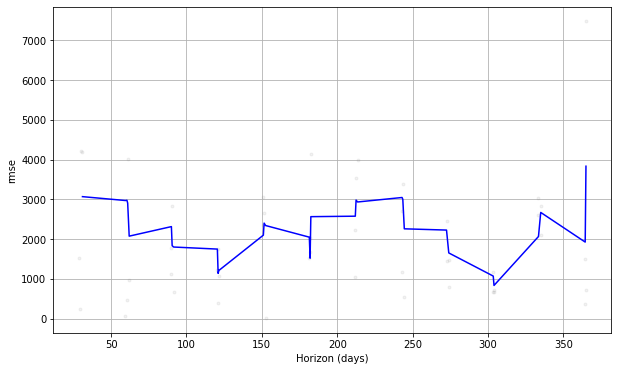

In [67]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [68]:
print('El RMSE es:', df_p.rmse.median())

El RMSE es: 2258.7756424516815


In [69]:
df_p = performance_metrics(df_cv, rolling_window = 1)

In [70]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,365 days,5.788701e+06,2405.971849,1928.802606,0.008444,0.006939,0.008413,0.833333


In [71]:
comp_pred['PROPHET'] = prophet_pred['yhat']
comp_pred

,ARIMA,SARIMA,PROPHET
57,229994.28125,229160.760417,229202.152347
58,229994.28125,228547.875000,229197.409952
59,229994.28125,226810.406250,229521.957237
60,229994.28125,226547.197917,229305.171400
61,229994.28125,227522.197917,230163.294508
62,229994.28125,232457.968750,234080.459470
63,229994.28125,237446.479167,237225.903740
64,229994.28125,239957.218750,240033.160925
65,229994.28125,241601.208333,242176.968292
66,229994.28125,241308.260417,242252.756189


In [72]:
comp_error['PROPHET'] = [df_p['mse'][0], df_p['rmse'][0], df_p['mape'][0]]
comp_error

,ARIMA,SAMRIMA,PROPHET
MSE,7.505329e+07,4.118627e+06,5.788701e+06
RMSE,8.663330e+03,2.029440e+03,2.405972e+03
MAPE,3.025849e+00,6.301242e-01,8.444170e-03


---

# LSTM

In [73]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [74]:
df_LSTM = pd.DataFrame(df_ts['MedianListingPrice_AllHomes'])
df_LSTM

,MedianListingPrice_AllHomes
Date,
2012-01-01,186217.290000
2012-02-01,186866.940000
2012-03-01,189243.830000
2012-04-01,190602.200000
2012-05-01,190900.500000
...,...
2017-08-01,241460.319149
2017-09-01,239093.097826
2017-10-01,238629.880435


In [75]:
size = int(len(df_LSTM) * 0.8)

train_LSTM, test_LSTM = df_LSTM[0:size], df_LSTM[size:len(df_LSTM)]

In [76]:
# Escalar los datos a un rango entre (-1,1) para favorecer el proceso de cálculo de la red neuronal
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_LSTM)
scaled_train_data = scaler.transform(train_LSTM)
scaled_test_data = scaler.transform(test_LSTM)

In [77]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [78]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(200, input_shape=(n_input, n_features)))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mse', optimizer='adam')
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [79]:
LSTM_model.fit_generator(generator,epochs=25)

Epoch 1/25
45/45 [==============================] - 1s 3ms/step - loss: 0.0572
Epoch 2/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0301
Epoch 3/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0314
Epoch 4/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0273
Epoch 5/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0250
Epoch 6/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0196
Epoch 7/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 8/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0211
Epoch 9/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 10/25
45/45 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 11/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0215
Epoch 12/25
45/45 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 13/25
45/45 [==============================

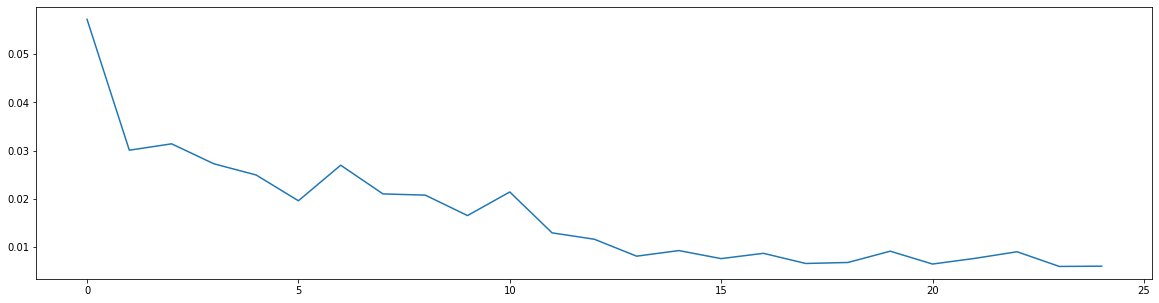

In [80]:
perdida_LSTM = LSTM_model.history.history['loss']
plt.figure(figsize=(20,5))
plt.xticks()
plt.plot(range(len(perdida_LSTM)),perdida_LSTM);

In [81]:
LSTM_prediccion_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test)):   
    LSTM_pred = LSTM_model.predict(current_batch)[0]
    LSTM_prediccion_scaled.append(LSTM_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[LSTM_pred]],axis=1)

1/1 [==============================] - 0s 13ms/step


In [82]:
LSTM_prediccion = scaler.inverse_transform(LSTM_prediccion_scaled)

In [83]:
MSE_LSTM = mean_squared_error(test_LSTM, LSTM_prediccion)
RMSE_LSTM = np.sqrt(MSE_LSTM)

print('MSE:', MSE_LSTM)
print('RMSE:', RMSE_LSTM)

MSE: 29707648.125572048
RMSE: 5450.472284634796


In [84]:
MAPE_LSTM = mape(test_LSTM, LSTM_prediccion) 
print('MAPE: ',round(MAPE_LSTM[0],2),'%')

MAPE:  1.94 %


In [85]:
index_date_test = df_ts.tail(15).index

In [86]:
df_pred_LSTM = pd.DataFrame(LSTM_prediccion, index= index_date_test)

In [87]:
df_pred_LSTM.rename(columns = {0:'LSTM_pred'}, inplace=True)

In [88]:
df_pred_LSTM

,LSTM_pred
Date,
2016-10-01,228986.528522
2016-11-01,229660.504687
2016-12-01,232002.627720
2017-01-01,235557.134981
2017-02-01,239116.537819
2017-03-01,241460.213243
2017-04-01,242170.038556
2017-05-01,241642.275460
2017-06-01,240631.336161


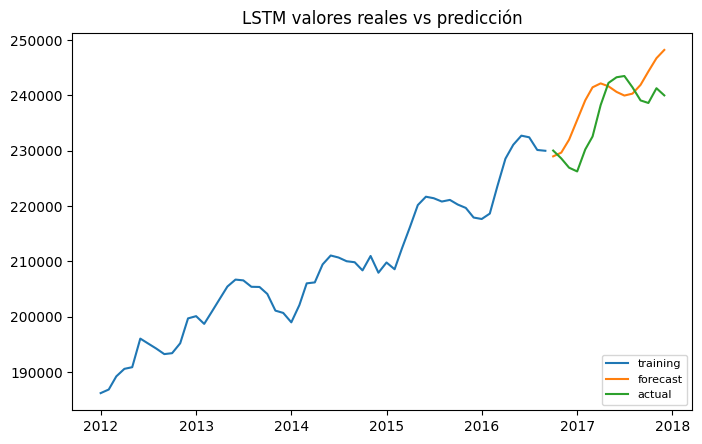

In [89]:
# Plot
plt.figure(figsize=(8,5), dpi=100)

plt.plot(train_LSTM, label='training')
plt.plot(df_pred_LSTM, label='forecast')
plt.plot(test_LSTM, label='actual')
plt.title('LSTM valores reales vs predicción')
plt.legend(loc='lower right', fontsize=8)
plt.show();

In [90]:
comp_pred['LSTM'] = df_pred_LSTM['LSTM_pred'][0]
comp_pred

,ARIMA,SARIMA,PROPHET,LSTM
57,229994.28125,229160.760417,229202.152347,228986.528522
58,229994.28125,228547.875000,229197.409952,228986.528522
59,229994.28125,226810.406250,229521.957237,228986.528522
60,229994.28125,226547.197917,229305.171400,228986.528522
61,229994.28125,227522.197917,230163.294508,228986.528522
62,229994.28125,232457.968750,234080.459470,228986.528522
63,229994.28125,237446.479167,237225.903740,228986.528522
64,229994.28125,239957.218750,240033.160925,228986.528522
65,229994.28125,241601.208333,242176.968292,228986.528522
66,229994.28125,241308.260417,242252.756189,228986.528522


In [91]:
comp_error['LSTM'] = [MSE_LSTM, RMSE_arima, MAPE_LSTM[0]]
comp_error

,ARIMA,SAMRIMA,PROPHET,LSTM
MSE,7.505329e+07,4.118627e+06,5.788701e+06,2.970765e+07
RMSE,8.663330e+03,2.029440e+03,2.405972e+03,8.663330e+03
MAPE,3.025849e+00,6.301242e-01,8.444170e-03,1.937605e+00


---

# - CONCLUSIÓN

In [92]:
comp_pred['test'] = test['MedianListingPrice_AllHomes']

### Predicciones

In [93]:
comp_pred

,ARIMA,SARIMA,PROPHET,LSTM,test
57,229994.28125,229160.760417,229202.152347,228986.528522,230033.729167
58,229994.28125,228547.875000,229197.409952,228986.528522,228616.166667
59,229994.28125,226810.406250,229521.957237,228986.528522,226939.020833
60,229994.28125,226547.197917,229305.171400,228986.528522,226262.927083
61,229994.28125,227522.197917,230163.294508,228986.528522,230237.666667
62,229994.28125,232457.968750,234080.459470,228986.528522,232575.074468
63,229994.28125,237446.479167,237225.903740,228986.528522,238247.010638
64,229994.28125,239957.218750,240033.160925,228986.528522,242251.585106
65,229994.28125,241601.208333,242176.968292,228986.528522,243275.840426
66,229994.28125,241308.260417,242252.756189,228986.528522,243501.765957


### - Evaluacion de errores

In [94]:
comp_error

,ARIMA,SAMRIMA,PROPHET,LSTM
MSE,7.505329e+07,4.118627e+06,5.788701e+06,2.970765e+07
RMSE,8.663330e+03,2.029440e+03,2.405972e+03,8.663330e+03
MAPE,3.025849e+00,6.301242e-01,8.444170e-03,1.937605e+00


- Al analizar los resultados de las métricas de evaluación y las gráficas de predicción se determina que los modelos SARIMA y Prophet son los que mejor ajustan al problema. Seleccionamos Prophet como modelo para nuestras predicciones.